# MBML Project

The project explores the application of Variational Autoencoders (VAEs) and their extensions for classification tasks, particularly in scenarios with limited labeled data. The key aspects of the project are:

1. VAE with Sequential Classifier:
It implements a standard VAE in Pyro and then adds a multiclass linear classifier on top of the latent space to perform supervised classification. This allows comparing classification performance using the learned latent representation.

2. Supervised VAE (sVAE):
It uses the standard VAE architecture by including the classifier also in the VAE, this allows the latent space to perform both recontruction and classification tasks.

3. Semi-Supervised VAE (ssVAE):
It extends the VAE to a semi-supervised setting, enabling the model to learn from both labeled and unlabeled data. The ssVAE reconstructs input data and predicts labels, aiming to improve classification accuracy when only a fraction of the data is labeled.

4. Active Learning with uncertainty-based Sampling:
It employs an active learning strategy to select the most informative (high entropy) unlabeled data points for labeling. This aims to further enhance the model's performance by focusing on data points that the model is most uncertain about.

### Getting started

First we need to load the main libaries in this project.

In [66]:
import numpy as np
import torch
import torch.nn as nn
from mnist_cached import MNISTCached as MNIST
from mnist_cached import setup_data_loaders

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import pyro.poutine as poutine
import pandas as pd

# matplotlib style options
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
warnings.filterwarnings("ignore")

Esnure that notebook is reproducible

In [2]:
torch.manual_seed(1234)
np.random.seed(1234)

# 1. VAE with Sequential Classifier

### Purpose

In this first section, the goal is to create a model applicable of predicting accurate labels for the MNIST dataset. 
The expectation is that an efficient Autoencoder will ensure that a compressed latent space, will preserved the "predictable" features of the image, hence it should also make classification on such easier.

Hence, first step of the sequential VAE-based classifier, is to define and train an autoencoder.

This first part will be based on the code presented in week 11.

As an addition to the previously presented code, the update has added a function for reconstruction accuracy. 

In [3]:
# define the PyTorch module that parameterizes the
# diagonal gaussian distribution q(z|x)
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, input_dim):
        self.input_dim = input_dim
        super().__init__()
        # setup the three linear transformations used
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()
        self.reset_parameters()

    def forward(self, x):
        # define the forward computation on the image x
        # first shape the mini-batch to have pixels in the rightmost dimension
        x = x.reshape(-1, self.input_dim)
        # then compute the hidden units
        hidden = self.softplus(self.fc1(x))
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        return z_loc, z_scale
    
    def reset_parameters(self):
        self.fc1.reset_parameters()
        self.fc21.reset_parameters()
        self.fc22.reset_parameters()


# define the PyTorch module that parameterizes the
# observation likelihood p(x|z)
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, output_dim, binary=False):
        self.binary = binary
        super().__init__()
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, output_dim)
        if not self.binary:
            self.fc22 = nn.Linear(hidden_dim, output_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, z):
        # define the forward computation on the latent z
        # first compute the hidden units
        hidden = self.softplus(self.fc1(z))
        # return the parameter for the output Bernoulli
        # each is of size batch_size x input_dim
        if self.binary:
            out = torch.sigmoid(self.fc21(hidden))
        else:
            out = (self.fc21(hidden), self.softplus(self.fc22(hidden)))
        return out
    
    def reset_parameters(self):
        self.fc1.reset_parameters()
        self.fc21.reset_parameters()
        self.fc22.reset_parameters()

In [4]:
# define a PyTorch module for the VAE
class VAE(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, z_dim=50, hidden_dim=400, input_dim=784, binary=False, use_cuda=False):
        self.input_dim = input_dim
        self.binary = binary
        super().__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim, input_dim)
        self.decoder = Decoder(z_dim, hidden_dim, input_dim, binary=binary)

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # define the model p(x|z)p(z)
    def model(self, x):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            z_loc = torch.zeros(x.shape[0], self.z_dim)
            z_scale = torch.ones(x.shape[0], self.z_dim)
            z = pyro.sample("z", dist.Normal(z_loc, z_scale).to_event(1))
            img = self.decoder.forward(z)
            if self.binary:
                # sample from the Bernoulli distribution
                pyro.sample("obs", dist.Bernoulli(img, validate_args=False).to_event(1), obs=x.reshape(-1, self.input_dim))

    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        
        with pyro.plate("data", x.shape[0]):
            z_loc, z_scale = self.encoder.forward(x)
            z = pyro.sample("z", dist.Normal(z_loc, z_scale).to_event(1))


    # define a helper function for reconstructing images (this will useful later - ignore for now)
    def reconstruct_img(self, x):
        # encode image x
        z_loc, z_scale = self.encoder(x)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder(z)
        return loc_img
    
    # define a helper function for computing the reconstruction accuracy
    def recontruct_accuracy(self, x):
        # first we need to reconstruct the image
        recon = self.reconstruct_img(x)
        # then we need to binarize the reconstructed image
        recon_bin = (recon > 0.5).float()
        x_bin = (x > 0.5).float()
        # finally, we compute the accuracy
        accuracy = (recon_bin == x_bin).float().mean().item()
        return accuracy
    

### Performance evaluation
This next code is an establishment of general purpose performance evaluation, hence functions that can be reused throughout the project have been defined

In [5]:
def compute_loss(data_loader, svi, supervised=False):
    # compute the training loss
    loss = []
    for x, y in data_loader:
        # Convert y from one-hot to integer
        y = np.argmax(y, axis=1)
        # Send to CUDA if available
        if use_cuda:
            x = x.cuda()
            y = y.cuda()
        # run the model and guide
        if supervised:
            elbo = svi.evaluate_loss(x,y)
        else:
            elbo = svi.evaluate_loss(x)
        loss.append(elbo)
    return np.mean(loss)

def compute_reconstruct_accuracy(data_loader, model):
    # compute the training accuracy
    dataset_accuracy = []
    for x, _ in data_loader:
        if use_cuda:
            x = x.cuda()
        # run the model and guide
        accuracy = model.recontruct_accuracy(x)
        dataset_accuracy.append(accuracy)
    return np.mean(dataset_accuracy)

def compute_classify_accuracy(data_loader, model):
    # compute the training accuracy
    dataset_accuracy = []
    for x, y in data_loader:
        # Convert y from one-hot to integer
        y = np.argmax(y, axis=1)
        # Send to CUDA if available
        if use_cuda:
            x = x.cuda()
            y = y.cuda()
        # run the model and guide
        accuracy = model.accuracy(x, y)
        dataset_accuracy.append(accuracy)
    return np.mean(dataset_accuracy)

def evaluate_model(model, data_loader, svi, supervised=False):
    # Purpose is to evaluate the model on the given data loader. 
    # e.g. train or test set
    # The code is compatible with supervised and unsupervised training
    # compute the training loss
    loss = compute_loss(data_loader, svi, supervised=supervised)
    # compute the training accuracy
    if supervised:
        classify_accuracy = compute_classify_accuracy(data_loader, model)
        reconstruct_accuracy = compute_reconstruct_accuracy(data_loader, model)
        print(f"Loss: {loss:.4f}, Accuracy classifier: {classify_accuracy:.4f}, Accuracy recon: {reconstruct_accuracy:.4f}")
    else:
        classify_accuracy = 0
        reconstruct_accuracy = compute_reconstruct_accuracy(data_loader, model)
        print(f"Loss: {loss:.4f}, Accuracy recon: {reconstruct_accuracy:.4f}")
    return loss, reconstruct_accuracy, classify_accuracy

From the above, the VAE used in this project has been defined. Yet, it is desired to define the classification model, to predict based on the latent space.

1. Define a Pyro model and guide for a multiclass linear classifier. We will create a K-class linear model $y ∼ \text{Categorical}(logits = z_{loc}  W + b)$.  
    - Please note, that W (weight) is defined as $\beta$ and b (bias) as $\alpha$, this is oposite of usual convention.

2. Create performance measures

In [6]:
class VAEClassifier:
    def __init__(self, vae, num_classes):
        super().__init__()
        self.vae = vae
        self.num_classes = num_classes

    def model(self, x, obs=None):
        z_loc, _ = self.vae.encoder(x)
        alpha = pyro.sample("alpha", pyro.distributions.Normal(0., 1.).expand( [self.num_classes]).to_event())
        beta = pyro.sample("beta", pyro.distributions.Normal(0., 1.).expand([z_loc.shape[1], self.num_classes]).to_event())
        logits = z_loc @ beta + alpha
        with pyro.plate("data", z_loc.shape[0]):
            y = pyro.sample("y", pyro.distributions.Categorical(logits=logits), obs=obs, infer={"is_auxiliary": True})

    def guide(self, x, obs=None):
        z_loc, _ = self.vae.encoder(x)
        z_dim = z_loc.shape[1]
        # approximate posterior over alpha and beta
        alpha_loc = pyro.param("alpha_loc", torch.zeros(self.num_classes))
        alpha_scale = pyro.param("alpha_scale", torch.ones(self.num_classes))
        alpha = pyro.sample("alpha", dist.Normal(alpha_loc, alpha_scale).to_event(1))

        beta_loc = pyro.param("beta_loc", torch.zeros(z_dim, self.num_classes))
        beta_scale = pyro.param("beta_scale", torch.ones(z_dim, self.num_classes))
        beta = pyro.sample("beta", dist.Normal(beta_loc, beta_scale).to_event(2))


        with pyro.plate("data", z_loc.shape[0]):
            y = pyro.sample("y", pyro.distributions.Categorical(logits=z_loc @ beta + alpha) 
                            , infer={"is_auxiliary": True})
    
    def classifier(self, x):
        # Enable evaluation of classification from the model
        z_loc, _ = self.vae.encoder(x)
        alpha_loc = pyro.param("alpha_loc")
        beta_loc = pyro.param("beta_loc")
        logits = z_loc @ beta_loc + alpha_loc
        return torch.argmax(logits, dim=1)

    def accuracy(self, x, y):
        # Compute the accuracy of the classifier
        y_pred = self.classifier(x)
        accuracy = (y == y_pred).float().mean().item()
        return accuracy


#### Loading the data
With everything setup for the first test. We can now load the data.

In [7]:
# Load the MNIST dataset
loaders = setup_data_loaders(MNIST, use_cuda=False, batch_size=250, sup_num=49000)
data_loader = loaders["sup"]
test_loader = loaders["test"]

# Define the number of classes
num_classes = 10

With the dataloader defined in the Course material, there where issues related to the active learning strategy.
The original implementation would shuffle each time a batch was fetched, making impossible to pick certain images for labelling. 
Hence a static loader is written, to overwrite the shuffled but dynamic dataset that had just been loaded. (This code with generated with assistance from LLM)


In [8]:
from torch.utils.data import Dataset, DataLoader

class CopiedDataset(Dataset):
    def __init__(self, original_loader):
        self.data = []
        for x, y in original_loader:
            self.data.append((x.clone(), y.clone()))
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

def copy_dataloader(original_loader):
    # Extract batch size and other relevant parameters from original loader
    batch_size = original_loader.batch_size
    shuffle = False
    
    # Create dataset from copied data
    copied_dataset = CopiedDataset(original_loader)
    
    # Return a new DataLoader with same configuration
    return DataLoader(
        copied_dataset,
        batch_size=1,  # Each item is already a batch
        shuffle=shuffle,
        collate_fn=lambda x: x[0]  # Return the batch directly
    )

# Usage example:
data_loader = copy_dataloader(data_loader)

### Setup training parameters
For simplicity and comparisons, the same inference algorithm and optimizer has been used throughout the project.
The models are trained for 100 Epochs, even though a higher number might be optimal. 
The reason for this is that the project aims its focus on how a bayesian approach can be incorporated in active learning, hence the change in efficiency is measured rather than optimum effectiveness.

In [9]:
# To keep things simple, and performance comparable, 
# we predefine the optimizer and the learning rate
adam_args = {"lr": 1.0e-3}
optimizer = Adam(adam_args)

# setup the inference algorithm
elbo = Trace_ELBO()

# Code is optimized for GPU, but can run on CPU as well
use_cuda = False

# Fixed amount of epochs for all models
num_epochs = 100


Yet, we are ready to train:

In [10]:
# clear model parameters prior to training
pyro.clear_param_store()

# setup the VAE
vae = VAE(use_cuda=use_cuda, z_dim=50, hidden_dim=400, input_dim=784, binary=True)

# setup the optimizer
svi = SVI(vae.model, vae.guide, optimizer, loss=elbo)

train_elbo = {}
test_elbo = {}
# training loop
for epoch in range(num_epochs):
    # initialize loss accumulator
    epoch_loss = 0.0
    # do a training epoch over each batch x returned
    # by the data loader
    for x, _ in data_loader:
        # if on GPU put batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x)
    if epoch % 5 == 0:
        # compute the training loss
        print("Epoch %d" % epoch)
        # compute the training and test loss and reconstruction accuracy
        print("Training: ")
        _, _, _ = evaluate_model(vae, data_loader, svi, supervised=False)
        print("Testing: ")
        _, _, _ = evaluate_model(vae, test_loader, svi, supervised=False)

Epoch 0
Training: 
Loss: 41166.1047, Accuracy recon: 0.9116
Testing: 
Loss: 40861.1021, Accuracy recon: 0.9133
Epoch 5
Training: 
Loss: 29650.2124, Accuracy recon: 0.9535
Testing: 
Loss: 29305.2462, Accuracy recon: 0.9549
Epoch 10
Training: 
Loss: 27733.3301, Accuracy recon: 0.9602
Testing: 
Loss: 27498.0889, Accuracy recon: 0.9611
Epoch 15
Training: 
Loss: 26927.1844, Accuracy recon: 0.9630
Testing: 
Loss: 26737.5525, Accuracy recon: 0.9636
Epoch 20
Training: 
Loss: 26560.3615, Accuracy recon: 0.9643
Testing: 
Loss: 26424.9921, Accuracy recon: 0.9649
Epoch 25
Training: 
Loss: 26337.4635, Accuracy recon: 0.9650
Testing: 
Loss: 26232.8546, Accuracy recon: 0.9654
Epoch 30
Training: 
Loss: 26159.9929, Accuracy recon: 0.9658
Testing: 
Loss: 26072.7201, Accuracy recon: 0.9663
Epoch 35
Training: 
Loss: 26059.5137, Accuracy recon: 0.9659
Testing: 
Loss: 25996.5421, Accuracy recon: 0.9662
Epoch 40
Training: 
Loss: 25887.7842, Accuracy recon: 0.9663
Testing: 
Loss: 25851.9244, Accuracy recon: 0

The above showed that a high performance VAE has been created. This will be used in the further analysis, as the encoded images will feed into our classifier.

For documentation purposes, the PGM has been exported below

In [65]:
# model_graph = pyro.render_model(
#     vae.model, 
#     model_args=(x,), 
#     render_distributions=True,
#     render_params=False, 
#     filename="pgm_visual/vae_model_graph.png" 
# )

# guide_graph = pyro.render_model(
#     vae.guide,
#     model_args=(x,),
#     render_distributions=True,
#     render_params=False,
#     filename="pgm_visual/vae_guide_graph.png" # Optional: saves to file
# )
print("PGM Visualization Export Done!")

PGM Visualization Export Done!


### Train the classifier in Pyro using SVI

You can run standard Pyro SVI over these model/guide definitions. The guide function had been manually created, this to allow a global performance evaluation function, however, AutoGuide could've also been used. 

The model is trained and the classifier evaluated:

In [12]:
# Clear out any existing parameter values
pyro.clear_param_store()
optimizer = Adam({"lr": 1.0e-3})

sequential_classifier = VAEClassifier(vae, num_classes)

# Setup SVI
svi_classifier = SVI(
    model=sequential_classifier.model,
    guide=sequential_classifier.guide,
    optim=optimizer,
    loss=Trace_ELBO(num_particles=3),
)

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for x, y in data_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
            y = y.cuda()
        y = np.argmax(y, axis=1) 
        # do ELBO gradient and accumulate loss
        epoch_loss += svi_classifier.step(x, y)
    if epoch % 5 == 0:
        # compute the training loss
        print("Epoch %d" % epoch)
        print("Train accuracy: %.2f" % (compute_classify_accuracy(data_loader, sequential_classifier)))
        print("Test accuracy: %.2f" % (compute_classify_accuracy(test_loader, sequential_classifier)))
        


Epoch 0
Train accuracy: 0.81
Test accuracy: 0.82
Epoch 5
Train accuracy: 0.83
Test accuracy: 0.84
Epoch 10
Train accuracy: 0.84
Test accuracy: 0.85
Epoch 15
Train accuracy: 0.84
Test accuracy: 0.85
Epoch 20
Train accuracy: 0.84
Test accuracy: 0.86
Epoch 25
Train accuracy: 0.84
Test accuracy: 0.86
Epoch 30
Train accuracy: 0.85
Test accuracy: 0.86
Epoch 35
Train accuracy: 0.85
Test accuracy: 0.86
Epoch 40
Train accuracy: 0.85
Test accuracy: 0.86
Epoch 45
Train accuracy: 0.85
Test accuracy: 0.86
Epoch 50
Train accuracy: 0.85
Test accuracy: 0.86
Epoch 55
Train accuracy: 0.85
Test accuracy: 0.86
Epoch 60
Train accuracy: 0.85
Test accuracy: 0.86
Epoch 65
Train accuracy: 0.85
Test accuracy: 0.86
Epoch 70
Train accuracy: 0.85
Test accuracy: 0.86
Epoch 75
Train accuracy: 0.85
Test accuracy: 0.86
Epoch 80
Train accuracy: 0.85
Test accuracy: 0.87
Epoch 85
Train accuracy: 0.85
Test accuracy: 0.86
Epoch 90
Train accuracy: 0.85
Test accuracy: 0.86
Epoch 95
Train accuracy: 0.86
Test accuracy: 0.86


From the above, a baseline classifier has been adopted. We expect this to be far from optimum, hence, we can investigate how integrating the classifier into the VAE will change performance. 

But first, let us save the PGM.

In [64]:
# model_graph = pyro.render_model(
#     sequential_classifier.model, 
#     model_args=(x,), 
#     render_distributions=True,
#     render_params=False, 
#     filename="pgm_visual/classifier_model_graph.png" 
# )

# guide_graph = pyro.render_model(
#     sequential_classifier.guide,
#     model_args=(x,),
#     render_distributions=True,
#     render_params=False,
#     filename="pgm_visual/classifier_guide_graph.png" # Optional: saves to file
# )
print("PGM Visualization Export Done!")

PGM Visualization Export Done!


# 2. Supervised VAE (sVAE):
We are now ready to increase the effectiveness of the latent space and the classifier.
- We need to update the VAE to also compute the image-classification
- The loss should be a combination of both Reconstruction and classification loss
- We might need to add a weight to the losses, e.g. to the classification loss
- The function should allow for semi-supervised VAE
    - Therefore, if image is unsupervised, we assign y= -1.
    - Then we can mask out the unlabelled data from the classifier
    - Be aware, pyro will not understand that these have been excluded until calculating loss
    - Therefore, we will need to assign the unlabelled data to a valid class (within the mask)

### a) Definition of Supervised VAE

In [14]:
# define a PyTorch module for the VAE
class ssVAE(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, z_dim=50, hidden_dim=400, input_dim=784, binary=False, use_cuda=False):
        self.input_dim = input_dim
        self.binary = binary
        super().__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim, input_dim)
        self.decoder = Decoder(z_dim, hidden_dim, input_dim, binary=binary)

        if use_cuda:
            # Send to GPU
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # define the model p(x|z)p(z)
    def model(self, x, y=None, fraction=1.0):
        BATCH_SIZE = x.shape[0]
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        alpha = pyro.sample("alpha", pyro.distributions.Normal(0., 1.).expand([num_classes]).to_event(1))
        beta = pyro.sample("beta", pyro.distributions.Normal(0., 1.).expand([self.z_dim, num_classes]).to_event(2))
        with pyro.plate("data", x.shape[0]):
            z_loc = torch.zeros(x.shape[0], self.z_dim)
            z_scale = torch.ones(x.shape[0], self.z_dim)
            z = pyro.sample("z", dist.Normal(z_loc, z_scale).to_event(1))
            # Reconstruct image
            img = self.decoder.forward(z)

            ##### HERE COMES THE NEW PARTS ####
            # Prepare for classification
            logits =   z @ beta + alpha
            # sample from the Bernoulli distribution
            pyro.sample("obs", dist.Bernoulli(img, validate_args=False).to_event(1), obs=x.reshape(-1, self.input_dim))
            # Now we need to establish our mask
            is_labelled = (y != -1)
            # We then update the unlabelled data to a valid class
            y[~is_labelled] = 0 # this will be ignored in the loss
            # Then we only sample over the mask
            with poutine.mask(mask=is_labelled): # Only computing loss on the labelled data
                # Add a scale factor to the loss
                with pyro.poutine.scale(scale=1/fraction):
                    # Sample only on the labeled data
                    pyro.sample("y", dist.Categorical(logits=logits), obs=y, infer={'is_auxiliary': True})

    def guide(self, x, y=None, fraction=None):
        # register PyTorch modules with Pyro
        pyro.module("encoder", self.encoder)

        # approximate posterior over alpha and beta
        alpha_loc = pyro.param("alpha_loc", torch.zeros(num_classes))
        alpha_scale = pyro.param("alpha_scale", torch.ones(num_classes))
        alpha = pyro.sample("alpha", dist.Normal(alpha_loc, alpha_scale).to_event(1))

        beta_loc = pyro.param("beta_loc", torch.zeros(self.z_dim, num_classes))
        beta_scale = pyro.param("beta_scale", torch.ones(self.z_dim, num_classes))
        beta = pyro.sample("beta", dist.Normal(beta_loc, beta_scale).to_event(2))
        
        with pyro.plate("data", x.shape[0]):
            # approximate posterior over z
            z_loc, z_scale = self.encoder.forward(x)
            z = pyro.sample("z", dist.Normal(z_loc, z_scale).to_event(1))

            # for unlabeled data, sample y from the classifier
            if y is not None:
                mask_unlabelled = (y == -1)
                if torch.any(mask_unlabelled): # Ignore this for the fully supervised case
                    logits = z @ beta + alpha
                    with poutine.mask(mask=mask_unlabelled):
                        pyro.sample("y", dist.Categorical(logits=logits),infer={'is_auxiliary': True})
                
    def classifier(self, x):
        z_loc, z_scale = self.encoder(x)
        z = z_loc
        alpha_loc = pyro.param("alpha_loc")
        beta_loc = pyro.param("beta_loc")
        logits = z @ beta_loc + alpha_loc
        return torch.argmax(logits, dim=1)

    # define a helper function for reconstructing images
    def reconstruct_img(self, x):
        # encode image x
        z_loc, z_scale = self.encoder(x)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder(z)
        return loc_img
    
    def recontruct_accuracy(self, x):
        recon = self.reconstruct_img(x)
        recon_bin = (recon > 0.5).float()
        x_bin = (x > 0.5).float()
        accuracy = (recon_bin == x_bin).float().mean().item()
        return accuracy

    def accuracy(self, x, y):
        y_pred = self.classifier(x)
        accuracy = (y == y_pred).float().mean().item()
        return accuracy

### b) Training Supervised VAE with Classifier

In [15]:

pyro.clear_param_store()

# setup the VAE
vae_classifier = ssVAE(use_cuda=use_cuda, z_dim=50, hidden_dim=400, input_dim=784, binary=True)

# setup the inference algorithm
elbo = Trace_ELBO()
svi = SVI(vae_classifier.model, vae_classifier.guide, optimizer, loss=elbo)

# training loop
for epoch in range(num_epochs):
    # initialize loss accumulator
    epoch_loss = 0.0

    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x, y in data_loader:
        # if on GPU put mini-batch into CUDA memory
        y = np.argmax(y, axis=1)
        if use_cuda:
            x = x.cuda()
            y = y.cuda()
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x, y)
    # Store average accuracy for this epoch

    if epoch % 5 == 0:
        # compute the training loss
        print("Epoch %d" % epoch)
        # compute the training and test loss, reconstruction accuracy and  classification accuracy
        print("Training: ")
        _, _, _ = evaluate_model(model=vae_classifier, data_loader=data_loader, svi = svi, supervised=True)
        print("Testing: ")
        _, _, _ = evaluate_model(vae_classifier, test_loader, svi, supervised=True)


Epoch 0
Training: 
Loss: 44866.9656, Accuracy classifier: 0.5236, Accuracy recon: 0.9062
Testing: 
Loss: 44549.8301, Accuracy classifier: 0.5445, Accuracy recon: 0.9079
Epoch 5
Training: 
Loss: 30811.3994, Accuracy classifier: 0.8580, Accuracy recon: 0.9528
Testing: 
Loss: 30512.7616, Accuracy classifier: 0.8722, Accuracy recon: 0.9539
Epoch 10
Training: 
Loss: 28517.7803, Accuracy classifier: 0.8838, Accuracy recon: 0.9601
Testing: 
Loss: 28271.9901, Accuracy classifier: 0.8949, Accuracy recon: 0.9610
Epoch 15
Training: 
Loss: 27657.9973, Accuracy classifier: 0.8939, Accuracy recon: 0.9629
Testing: 
Loss: 27457.3938, Accuracy classifier: 0.9045, Accuracy recon: 0.9636
Epoch 20
Training: 
Loss: 27258.5372, Accuracy classifier: 0.9019, Accuracy recon: 0.9639
Testing: 
Loss: 27111.6333, Accuracy classifier: 0.9120, Accuracy recon: 0.9646
Epoch 25
Training: 
Loss: 26969.2229, Accuracy classifier: 0.9092, Accuracy recon: 0.9647
Testing: 
Loss: 26840.0639, Accuracy classifier: 0.9179, Accur

The above clearly showed us, that the latent space could be utilized much better by including the classifier in the VAE. 

For evaluation purposes, we can now try to assess the reconstruction quality visually.

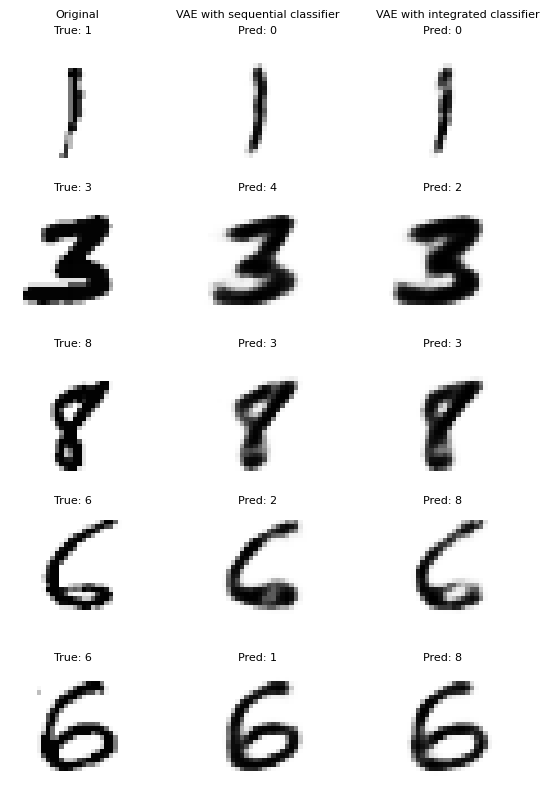

In [63]:
# Plot reconstructions with labels embedded in each subplot
def plot_reconstructions(x_batch, y_batch, vae, classifier, vae_classifier, use_cuda=False):
    fig, axs = plt.subplots(5, 3, figsize=(6, 8))

    # Pick the first 10 images
    indices = np.arange(10)
    for i in range(5):
        index = indices[i]
        test_img = x_batch[index]

        # Reconstructions from ssVAE and VAE
        reco_img_vae = vae_classifier.reconstruct_img(test_img)
        reco_img_vae_sequential = vae.reconstruct_img(test_img)
        
        # Classifier returns a distribution, so extract the predicted label
        pred_label = int(vae_classifier.classifier(test_img))

        pred_label_classifier = int(classifier.classifier(test_img))

        # True label
        true_label = np.argmax(y_batch[index])

        # Original image
        axs[i, 0].imshow(test_img.reshape(28, 28).detach().cpu().numpy(), cmap="Greys")
        axs[i, 0].set_title(f"True: {true_label}", fontsize=8)
        axs[i, 0].axis('off')
        
        # VAE with sequential classifier
        axs[i, 1].imshow(reco_img_vae_sequential.reshape(28, 28).detach().cpu().numpy(), cmap="Greys")
        axs[i, 1].set_title(f"Pred: {pred_label_classifier}", fontsize=8)
        axs[i, 1].axis('off')
        
        # VAE with classifier
        axs[i, 2].imshow(reco_img_vae.reshape(28, 28).detach().cpu().numpy(), cmap="Greys")
        axs[i, 2].set_title(f"Pred: {pred_label}", fontsize=8)
        axs[i, 2].axis('off')

    # Overall titles for columns
    fig.text(0.6/3, 0.99, "Original", ha='center', fontsize=8)
    fig.text(1.5/3, 0.99, "VAE with sequential classifier", ha='center', fontsize=8)
    fig.text(2.5/3, 0.99, "VAE with integrated classifier", ha='center', fontsize=8)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.96)
    return fig

# Example usage:
x_batch, y_batch = next(iter(test_loader))
if use_cuda:
    x_batch = x_batch.cuda()
fig = plot_reconstructions(x_batch, y_batch, vae, sequential_classifier, vae_classifier, use_cuda)
plt.savefig("reconstructions.png", dpi=300, bbox_inches='tight')

# 3. Semi-supervised VAE with classifier
To achieve semi-supervision, we recreated dataset to include certain percentage of unlabeled data in each dataset.

### a) Data Loading with some data in each batch masked

This function will create a semi-supervised dataset, where ```1-ss_fraction``` will be unlabelled

In [17]:
def ss_loader(y, ss_fraction):    
    shape = y.shape
    N = len(y)
    # Number of labels to mask
    L1 = int(N * (1-ss_fraction))
    y_masked = y.clone()
    indices = torch.randperm(N)[:L1]
    
    # Set the selected indices to -1
    y_masked[indices] = -1
    
    # Return the tensor and the list of indices that were masked
    return y_masked.reshape(shape), indices.tolist()

### b) Defining a training and evaluation function for the semi-supervised VAE
In the coming sections, we will need to run semi-supervised training multiple times. Hence, for convenience we define a trainer.


In [18]:
def ss_trainer(data_loader, test_loader, svi, ssvae, idxs_unsup, num_epochs=100, verbose=False):
    # We want to completely retrain the model each time
    pyro.clear_param_store()

    # Store the results from the training
    evals = []

    # training loop
    for epoch in range(num_epochs):
        # initialize loss accumulator
        epoch_loss = 0.0
        # do a training epoch over each mini-batch x returned
        # by the data loader

        for i, (x, y) in enumerate(data_loader):
            y = np.argmax(y, axis=1) # Convert y from one-hot to integer
            idx_unsup_new = idxs_unsup[i] # Get the unlabeled indices for this batch
            y[idx_unsup_new] = -1 # Mask as unlabeled

            if use_cuda: # Send to CUDA if available
                x = x.cuda()
                y = y.cuda()
            unlabelled_fraction = len(idx_unsup_new) / len(y)
            epoch_loss += svi.step(x, y, fraction=1-unlabelled_fraction)
        if epoch % 5 == 0 and verbose:
            print("Epoch %d" % epoch)
            print(f"Training:")
            _, _, _ = evaluate_model(ssvae, data_loader, svi, supervised=True)
            print(f"Testing:")
            test_loss, test_recon, test_accuracy = evaluate_model(ssvae, test_loader, svi, supervised=True)
            evals.append([epoch, test_loss, test_recon, test_accuracy])
        
    return svi, ssvae, evals

### c) Semi-supervised training

The reference is this project is that we would like to achieve the best possible classificatio accuracy with just 50% labeled data.
Therefore we create a reference semi-supervised model, with labels picked at random.

In [19]:

pyro.clear_param_store()
use_cuda = False
# setup the VAE
ssvae = ssVAE(use_cuda=use_cuda, z_dim=50, hidden_dim=400, input_dim=784, binary=True)

svi = SVI(ssvae.model, ssvae.guide, optimizer, loss=elbo)

# Prepare semi-supervised data
fraction = 0.5
idxs_unsup = []

# Prepare randomly semi-labelled data
for x, y in data_loader:
    y = np.argmax(y, axis=1)
    y, idx_unsup = ss_loader(y, fraction)
    idxs_unsup.append(idx_unsup)

# training loop
svi, ssvae, _ = ss_trainer(data_loader, test_loader, svi, ssvae, idxs_unsup, num_epochs=100, verbose=True)

Epoch 0
Training:
Loss: 55618.1009, Accuracy classifier: 0.0931, Accuracy recon: 0.8723
Testing:
Loss: 55415.7251, Accuracy classifier: 0.0892, Accuracy recon: 0.8728
Epoch 5
Training:
Loss: 41841.9354, Accuracy classifier: 0.3238, Accuracy recon: 0.9200
Testing:
Loss: 41476.0289, Accuracy classifier: 0.3435, Accuracy recon: 0.9218
Epoch 10
Training:
Loss: 38267.0890, Accuracy classifier: 0.4732, Accuracy recon: 0.9275
Testing:
Loss: 37945.0892, Accuracy classifier: 0.4832, Accuracy recon: 0.9290
Epoch 15
Training:
Loss: 36158.4190, Accuracy classifier: 0.4836, Accuracy recon: 0.9354
Testing:
Loss: 35793.7965, Accuracy classifier: 0.5070, Accuracy recon: 0.9368
Epoch 20
Training:
Loss: 34618.9502, Accuracy classifier: 0.6346, Accuracy recon: 0.9410
Testing:
Loss: 34320.1640, Accuracy classifier: 0.6574, Accuracy recon: 0.9425
Epoch 25
Training:
Loss: 33787.5737, Accuracy classifier: 0.6051, Accuracy recon: 0.9435
Testing:
Loss: 33481.7172, Accuracy classifier: 0.6280, Accuracy recon: 0

### d) Analysis
We clearly saw from above that accuracy of the classifier was reduced significantly, with only 50% labelled data.

Now we wish to understand what happens with accuracy in the extreme case of scarse labelling.

In [20]:
# Reset parameters
pyro.clear_param_store()
use_cuda = False

# Setup the VAE
ssvae = ssVAE(use_cuda=use_cuda, z_dim=50, hidden_dim=400, input_dim=784, binary=True)
svi = SVI(ssvae.model, ssvae.guide, optimizer, loss=elbo)

# Test different fractions of labeled data
fractions = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
results = []
for fraction in fractions:
    print(f"\nTraining with {fraction*100:.1f}% labeled data")
    
    pyro.clear_param_store()
    use_cuda = False
    # setup the VAE
    ssvae = ssVAE(use_cuda=use_cuda, z_dim=50, hidden_dim=400, input_dim=784, binary=True)

    svi = SVI(ssvae.model, ssvae.guide, optimizer, loss=elbo)

    # Prepare semi-supervised data
    idxs_unsup = []
    for x, y in data_loader:
        # if on GPU put mini-batch into CUDA memory
        y = np.argmax(y, axis=1)
        y, idx_unsup = ss_loader(y, fraction)
        idxs_unsup.append(idx_unsup)

    # training loop
    svi, ssvae, test_result = ss_trainer(data_loader, test_loader, svi, ssvae, idxs_unsup, num_epochs=100, verbose=True)
    results.append(test_result)



Training with 1.0% labeled data
Epoch 0
Training:
Loss: 55330.8840, Accuracy classifier: 0.1126, Accuracy recon: 0.8752
Testing:
Loss: 55171.2235, Accuracy classifier: 0.1088, Accuracy recon: 0.8758
Epoch 5
Training:
Loss: 42147.4362, Accuracy classifier: 0.2304, Accuracy recon: 0.9173
Testing:
Loss: 41921.9993, Accuracy classifier: 0.2268, Accuracy recon: 0.9189
Epoch 10
Training:
Loss: 38493.1238, Accuracy classifier: 0.3812, Accuracy recon: 0.9304
Testing:
Loss: 38201.2748, Accuracy classifier: 0.3954, Accuracy recon: 0.9319
Epoch 15
Training:
Loss: 36258.3103, Accuracy classifier: 0.5275, Accuracy recon: 0.9353
Testing:
Loss: 35983.6437, Accuracy classifier: 0.5453, Accuracy recon: 0.9368
Epoch 20
Training:
Loss: 35118.8632, Accuracy classifier: 0.5447, Accuracy recon: 0.9385
Testing:
Loss: 34786.1304, Accuracy classifier: 0.5661, Accuracy recon: 0.9400
Epoch 25
Training:
Loss: 34632.5862, Accuracy classifier: 0.5449, Accuracy recon: 0.9406
Testing:
Loss: 34321.2898, Accuracy clas

In [ ]:
# Define a function to convert the results to a DataFrame
def train_eval_to_df(res):
    results = res.copy()
    df = pd.DataFrame(columns=["epoch", "loss", "recon", "accuracy", "fraction"])
    for i, train_result in enumerate(results):
        # Add the fraction to each row
        for row in train_result:
            row.append(fractions[i])
        # Append the rows to the DataFrame
        df = pd.concat([df, pd.DataFrame(train_result, columns=["epoch", "loss", "recon", "accuracy", "fraction"])], ignore_index=True)
    return df
df = train_eval_to_df(results)
print(df.head())

  epoch          loss     recon  accuracy  fraction
0     0  55171.223511  0.875799    0.1088      0.01
1     5  41921.999268  0.918883    0.2268      0.01
2    10  38201.274780  0.931899    0.3954      0.01
3    15  35983.643652  0.936768    0.5453      0.01
4    20  34786.130371  0.939971    0.5661      0.01


/var/folders/j2/78rqs17d54vbj7hx80n7ztwr0000gp/T/ipykernel_96032/4234945908.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(train_result, columns=["epoch", "loss", "recon", "accuracy", "fraction"])], ignore_index=True)


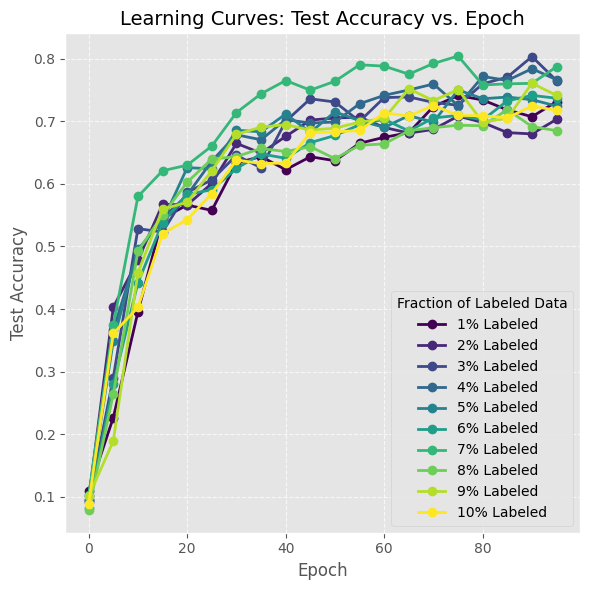

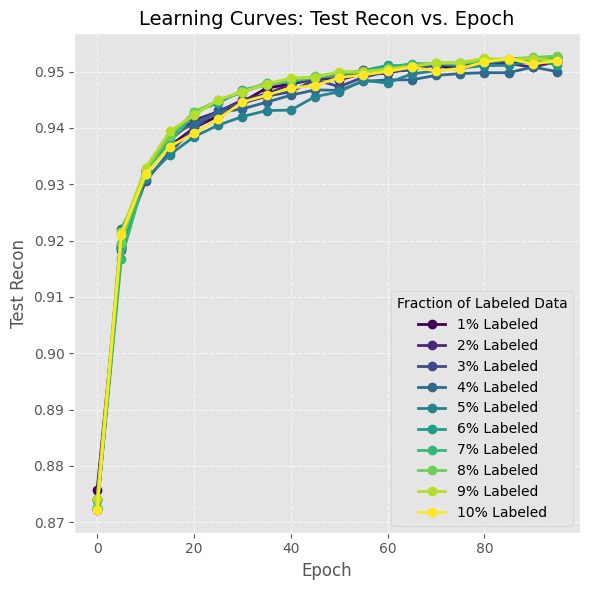

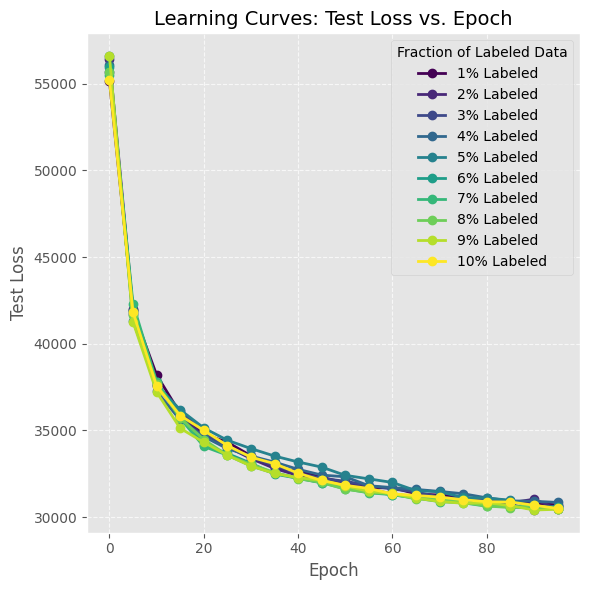

In [70]:

# Learning curves for different fractions
def plot_learning_curves(df, metric='accuracy'):
    """Plot learning curves for different fractions of labeled data"""
    plt.figure(figsize=(6, 6))
    
    # Get unique fractions
    fractions = sorted(df['fraction'].unique())
    
    # Use a color gradient
    colors = plt.cm.viridis(np.linspace(0, 1, len(fractions)))
    
    for i, fraction in enumerate(fractions):
        fraction_data = df[df['fraction'] == fraction]
        
        # Sort by epoch
        fraction_data = fraction_data.sort_values('epoch')
        
        plt.plot(fraction_data['epoch'], fraction_data[f'{metric}'], 
                 'o-', color=colors[i], linewidth=2, 
                 label=f'{fraction*100:.0f}% Labeled')
    
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel(f'Test {metric.capitalize()}', fontsize=12)
    plt.title(f'Learning Curves: Test {metric.capitalize()} vs. Epoch', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title='Fraction of Labeled Data')
    plt.tight_layout()
    plt.savefig(f'results/learning_curves_{metric}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Generate all plots
plot_learning_curves(df, 'accuracy')  # Classification accuracy curves
plot_learning_curves(df, 'recon')     # Reconstruction accuracy curves
plot_learning_curves(df, 'loss')      # Loss curves


From the above plots there a 3 take-aways:
1. The difference in performance is not improving much by increasing from 1% labelled to 10%. This could indicate, that a lot of the training data does not assist with improving accuracy.
2. The reconstruction accuracy does not seem to be affected by the amount of supervision.
3. The training is not suffering from overfitting at 100 Epochs.


(Please note: The code below was generated with assistance from LLM)

Confusion Matrix:
 [[ 920    0    3    9    8    3   29    2    5    1]
 [   0 1064    6    2   15    5    6    2   35    0]
 [  29    2  810   28   55    9    7   22   69    1]
 [   9    2    6  861    2   68    3   11   42    6]
 [   3    3    0    0  923    1   13    7    0   32]
 [  22    1    5   57    4  713   51    4   19   16]
 [   7    3    8    1   54   39  837    0    8    1]
 [   3    3   22    1   19    5    0  916    3   56]
 [   8    4    6   41   18   59    7   19  791   21]
 [  10    4    3   12  173    9    1  125   13  659]]
Most misclassified label: 9 (misclassified 350 times)


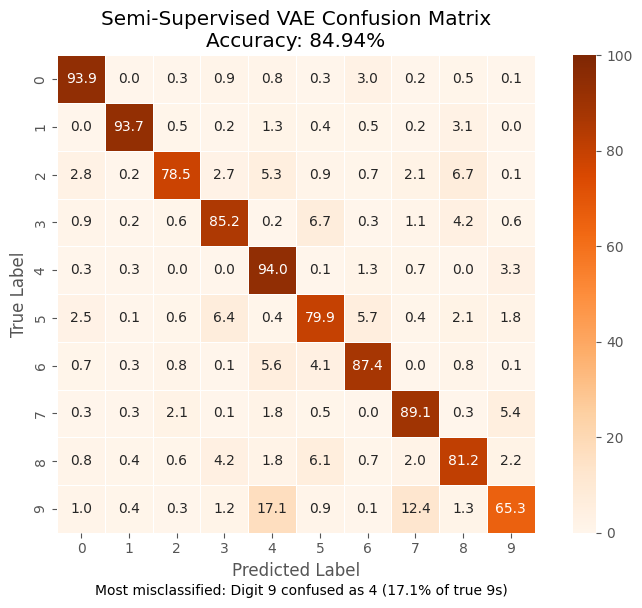

In [58]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def analyze_misclassifications(model, test_loader, use_cuda=False):

    all_preds = []
    all_true = []

    with torch.no_grad():
        for x, y in test_loader:
            if use_cuda:
                x = x.cuda()
                y = y.cuda()
            
            logits = model.classifier(x)
            true = torch.argmax(y, dim=1)  # assuming y is one-hot encoded
            
            all_preds.append(logits.cpu().numpy())
            all_true.append(true.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_true = np.concatenate(all_true)

    cm = confusion_matrix(all_true, all_preds)
    cm_no_diag = cm.copy()
    np.fill_diagonal(cm_no_diag, 0)
    misclassified_counts = cm_no_diag.sum(axis=1)
    most_misclassified_label = np.argmax(misclassified_counts)
    
    print("Confusion Matrix:\n", cm)
    print(f"Most misclassified label: {most_misclassified_label} (misclassified {misclassified_counts[most_misclassified_label]} times)")
    
    return cm, most_misclassified_label

def plot_confusion_matrix(cm, title='Confusion Matrix', cmap='Blues'):
    plt.figure(figsize=(8, 6))
    
    # Calculate row-wise percentages (for each true label)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Create a heatmap with percentages
    sns.heatmap(
        cm_percent, 
        annot=True,      # Show the percentages in each cell
        fmt='.1f',       # Show one decimal place
        cmap=cmap,       # Color scheme
        cbar=True,       # Show color bar
        square=True,     # Make cells square
        linewidths=.5,   # Width of the lines between cells
        xticklabels=range(10),  # MNIST has 10 classes (0-9)
        yticklabels=range(10),  # MNIST has 10 classes (0-9)
        vmin=0,          # Minimum value for the colormap
        vmax=100         # Maximum value for the colormap
    )
    
    # Compute overall accuracy for the title
    accuracy = np.trace(cm) / np.sum(cm) * 100
    
    # Add labels and title
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'{title}\nAccuracy: {accuracy:.2f}%')
    
    # Find most misclassified class (by percentage)
    cm_no_diag = cm_percent.copy()
    np.fill_diagonal(cm_no_diag, 0)
    most_misclassified = np.argmax(cm_no_diag.sum(axis=1))
    most_confused_as = np.argmax(cm_no_diag[most_misclassified])
    
    # Add a text note about most misclassified digit
    plt.figtext(
        0.5, 0.0, 
        f"Most misclassified: Digit {most_misclassified} confused as {most_confused_as} " +
        f"({cm_percent[most_misclassified, most_confused_as]:.1f}% of true {most_misclassified}s)",
        ha='center', fontsize=10
    )
    
    plt.tight_layout()
    return plt.gcf()

cm_ssvae, _ = analyze_misclassifications(ssvae, test_loader, use_cuda)

plot_confusion_matrix(cm_ssvae, "Semi-Supervised VAE Confusion Matrix", cmap="Oranges")
plt.show()
plt.savefig("results/ssvae_confusion_matrix.png")
plt.close()

Before moving on to active learning, the performance of the semi-supervised model is assessed.

In [24]:
_, _, _ = evaluate_model(ssvae, test_loader, svi, supervised=True)

Loss: 30408.0458, Accuracy classifier: 0.7357, Accuracy recon: 0.9518


In [25]:
# model_graph = pyro.render_model(
#     ssvae.model, 
#     model_args=(x,y), 
#     render_distributions=True,
#     render_params=False, 
#     filename="pgm_visual/ssvae_model_graph.png" 
# )

# guide_graph = pyro.render_model(
#     ssvae.guide,
#     model_args=(x,y),
#     render_distributions=True,
#     render_params=False,
#     filename="pgm_visual/ssvae_guide_graph.png" # Optional: saves to file
# )
print("PGM Visualization Export Done!")

PGM Visualization Export Done!


# 3. Active Learning - Uncertainty based sampling method
The purpose of Active Learning is to ensure that we label only the images that can help us improve learning efficiency.
The most common approach, and what we use in this project, is uncertainty based labelling. Hence we choose those images the causes the highest level of uncertainty.
As the VAE will access the full input dataset, the importance lies in finding the images that causes improvements in classification learning.

### a) Entropy-based uncertainty
Our first approach to label based on uncertainty, is a predictive Entropy-based active learning strategy.
- From each batch, choose the highest entropy samples to include in the training samples.

Many methods of such rely on an unsupervised method, where in this case the latent space would be chosen to maximize uncertainty. However, in our approach we benefit from the supervised case, and pick the datapoints with highest entropy on the logits.
\begin{equation}
    H[y | \mathbf{z}, \mathcal{D}_{\text{train}}] = - \sum_c p(y = c | \mathbf{z}, \mathcal{D}_{\text{train}}) \log p\left(y = c | \mathbf{z}, \mathcal{D}_{\text{train}}\right)
\end{equation}

In [26]:
def compute_entropy(x):
    z = ssvae.encoder(x)[0]
    alpha = pyro.param("alpha_loc")
    beta = pyro.param("beta_loc")
    logits =   z @ beta + alpha
    return dist.Categorical(logits=logits).entropy()

def remove_top_10_entropy(data_loader, idxs_unsup):
    # This function is to create entropy scores for the unsupervised data
    # and then remove the top 10 highest entropy scores
    # from the unsupervised data
    # This is done to label the most uncertain data points
    for i, (x, y) in enumerate(data_loader):
        y = np.argmax(y, axis=1)
        idx_unsup = np.sort(idxs_unsup[i])
        entropy = compute_entropy(x).detach().numpy()
        # Mask the unsupervised data points
        # and set the entropy to -1
        entropy[~np.isin(np.arange(len(entropy)),idx_unsup)] = -1
        # Get the top 10 highest entropy scores
        top_10_entropy = entropy.argsort()[-10:]
        # Remove the top 10 highest entropy scores from the unsupervised data
        idx_unsup_new = [idx for idx in idx_unsup if idx not in top_10_entropy]
        idxs_unsup[i] = idx_unsup_new
    return idxs_unsup

### Now we are ready to performing active learning on the labelling process.
Hence we will start with labelling 10% of the data at random. Afterwards we will labell 10/250 (4%) samples in each batch based on entropy. This means that the AL model will request labels where the logits have the highest level of chaos.


In [27]:
ssAL = ssVAE(use_cuda=use_cuda, z_dim=50, hidden_dim=400, input_dim=784, binary=True)

sviAL = SVI(ssAL.model, ssAL.guide, optimizer, loss=elbo)

# Prepare semi-supervised data
fraction = 0.1
idxs_unsup = []
for x, y in data_loader:
    # if on GPU put mini-batch into CUDA memory
    y = np.argmax(y, axis=1)
    y, idx_unsup = ss_loader(y, fraction)
    idxs_unsup.append(idx_unsup)

idxs_hist = [idxs_unsup.copy()]

# training loop
sviAL, ssAL, _ = ss_trainer(data_loader, test_loader, svi, ssvae, idxs_unsup, num_epochs=100, verbose=False)
label_frac = len(idxs_unsup[0])/len(next(iter(data_loader))[0])
results_entropy = []

for i in range(20): 
    if label_frac <= 0.5:
        break    
    idxs_unsup = remove_top_10_entropy(data_loader, idxs_unsup)
    label_frac = len(idxs_unsup[0])/len(next(iter(data_loader))[0])
    print(f"Labeled fraction: {(1-label_frac):.2f}")
    sviAL, ssAL, test_results = ss_trainer(data_loader, test_loader, sviAL, ssAL, idxs_unsup, num_epochs=num_epochs, verbose=True)
    _, _, _ = evaluate_model(ssAL, test_loader, sviAL, supervised=True)
    results_entropy.append(test_results)
    idxs_hist.append(idxs_unsup.copy())




Labeled fraction: 0.14
Epoch 0
Training:
Loss: 30463.2821, Accuracy classifier: 0.4170, Accuracy recon: 0.9550
Testing:
Loss: 30515.8857, Accuracy classifier: 0.4229, Accuracy recon: 0.9553
Epoch 5
Training:
Loss: 30208.8008, Accuracy classifier: 0.5281, Accuracy recon: 0.9559
Testing:
Loss: 30199.3332, Accuracy classifier: 0.5398, Accuracy recon: 0.9564
Epoch 10
Training:
Loss: 30130.5919, Accuracy classifier: 0.6275, Accuracy recon: 0.9556
Testing:
Loss: 30184.8064, Accuracy classifier: 0.6437, Accuracy recon: 0.9559
Epoch 15
Training:
Loss: 30128.7774, Accuracy classifier: 0.6923, Accuracy recon: 0.9561
Testing:
Loss: 30232.5389, Accuracy classifier: 0.7075, Accuracy recon: 0.9564
Epoch 20
Training:
Loss: 30001.5870, Accuracy classifier: 0.6561, Accuracy recon: 0.9561
Testing:
Loss: 30069.8479, Accuracy classifier: 0.6650, Accuracy recon: 0.9564
Epoch 25
Training:
Loss: 29892.1939, Accuracy classifier: 0.7254, Accuracy recon: 0.9563
Testing:
Loss: 29985.5981, Accuracy classifier: 0.

In [28]:
_, _, _ = evaluate_model(ssAL, test_loader, sviAL, supervised=True)


Loss: 28514.5529, Accuracy classifier: 0.8265, Accuracy recon: 0.9593


In [ ]:
from sklearn.manifold import TSNE
# For later analysis, we can save the encoded dataset as T-SNE and Confusion matrix

z_all = []
for x, _ in data_loader:
    if use_cuda:
        x = x.cuda()
    z = ssvae.encoder(x)
    z_all.append(z[0].detach().cpu().numpy())
z_all = np.concatenate(z_all, axis=0)
# Plot the t-SNE
tsne = TSNE(n_components=2, random_state=0)
z_all_tsne_entropy = tsne.fit_transform(z_all)

To visually assess performance, the confusion matrix is plotted again

In [ ]:
cm_entropy, _ = analyze_misclassifications(ssvae, test_loader, use_cuda)
plt.show()

### b) BALD Active Learning
Yet, we wish to implement and updated BALD algorithm, to see if we can pick datapoints to label even more efficient.
The algorithm is given by,
\begin{equation}
    \mathbb{I}[y, \boldsymbol{\omega} | \mathbf{z}, \mathcal{D}_{\text{train}}] = \mathbb{H}[y | \mathbf{z}, \mathcal{D}_{\text{train}}] - \mathbb{E}_{p(\boldsymbol{\omega} | \mathcal{D}_{\text{train}})} [\mathbb{H}[y | \mathbf{z}, \boldsymbol{\omega}]]
\end{equation}

Effectivly this algorithm picks datapoints with highest variance in the logits. However, we wish to redefine the BALD to actually utilize the probabilistic modelling mindset. Hence, we do sampling on the latent space z, perform classification on the sampled latent space. We then repeat the process and compute the disagreement.

In [30]:
from torch.nn.functional import one_hot
def BALD(x):
    # Compute the BALD score for the top 10 samples
    z_loc, z_scale = ssvae.encoder(x)
    alpha = pyro.param("alpha_loc")
    beta = pyro.param("beta_loc")
    scores = np.zeros((x.shape[0], 10))
    for i in range(1000): # we sample and evaluate multiple times
        z = dist.Normal(z_loc, z_scale).sample()
        logits =   z @ beta + alpha
        # Make one-hot encoding of the logits
        onehot = one_hot(logits.argmax(dim=1), num_classes=num_classes).detach().cpu().numpy()
        scores += np.array(onehot)
    # Compute the BALD score
    balds  = scores.max(axis=1)
    return balds

def remove_top_10_BALD(data_loader, idxs_unsup):
    # This function is to create BALD scores for the unsupervised data
    # and then remove the top 10 lowest BALD scores
    # from the unsupervised data
    # This is done to label the most uncertain data points
    for i, (x, y) in enumerate(data_loader):
        y = np.argmax(y, axis=1)
        idx_unsup = np.sort(idxs_unsup[i])
        balds = BALD(x)
        balds[~np.isin(np.arange(len(balds)),idx_unsup)] = 1000
        top_10_balds = balds.argsort()[:10]
        idx_unsup_new = [idx for idx in idx_unsup if idx not in top_10_balds]
        idxs_unsup[i] = idx_unsup_new
    return idxs_unsup

In [31]:
ssAL = ssVAE(use_cuda=use_cuda, z_dim=50, hidden_dim=400, input_dim=784, binary=True)

sviAL = SVI(ssAL.model, ssAL.guide, optimizer, loss=elbo)

# Prepare semi-supervised data
fraction = 0.1
idxs_unsup = []
for x, y in data_loader:
    # if on GPU put mini-batch into CUDA memory
    y = np.argmax(y, axis=1)
    y, idx_unsup = ss_loader(y, fraction)
    idxs_unsup.append(idx_unsup)

idxs_hist_BALD = [idxs_unsup.copy()]
results_BALD = []

# training loop
sviAL, ssAL, _ = ss_trainer(data_loader, test_loader, svi, ssvae, idxs_unsup, num_epochs=100, verbose=False)
label_frac = len(idxs_unsup[0])/len(next(iter(data_loader))[0])

for i in range(20): 
    if label_frac <= 0.5:
        break    
    idxs_unsup = remove_top_10_BALD(data_loader, idxs_unsup)
    label_frac = len(idxs_unsup[0])/len(next(iter(data_loader))[0])
    sviAL, ssAL, test_results = ss_trainer(data_loader, test_loader, sviAL, ssAL, idxs_unsup, num_epochs=num_epochs, verbose=True)
    print(f"Labeled fraction: {(1-label_frac):.2f}")
    _, _, _ = evaluate_model(ssAL, test_loader, sviAL, supervised=True)
    idxs_hist_BALD.append(idxs_unsup.copy())
    results_BALD.append(test_results)
 

Epoch 0
Training:
Loss: 28900.8879, Accuracy classifier: 0.3547, Accuracy recon: 0.9612
Testing:
Loss: 29315.1133, Accuracy classifier: 0.3715, Accuracy recon: 0.9606
Epoch 5
Training:
Loss: 28735.5885, Accuracy classifier: 0.6340, Accuracy recon: 0.9610
Testing:
Loss: 29062.9252, Accuracy classifier: 0.6452, Accuracy recon: 0.9605
Epoch 10
Training:
Loss: 28679.4572, Accuracy classifier: 0.6377, Accuracy recon: 0.9609
Testing:
Loss: 29002.4871, Accuracy classifier: 0.6548, Accuracy recon: 0.9605
Epoch 15
Training:
Loss: 28697.3814, Accuracy classifier: 0.6584, Accuracy recon: 0.9604
Testing:
Loss: 29035.0022, Accuracy classifier: 0.6655, Accuracy recon: 0.9600
Epoch 20
Training:
Loss: 28545.1992, Accuracy classifier: 0.6884, Accuracy recon: 0.9608
Testing:
Loss: 28938.6490, Accuracy classifier: 0.6905, Accuracy recon: 0.9602
Epoch 25
Training:
Loss: 28466.8165, Accuracy classifier: 0.7135, Accuracy recon: 0.9609
Testing:
Loss: 28839.3707, Accuracy classifier: 0.7196, Accuracy recon: 0

### c) Visual examination of picked labels
Yet, 2 algorithms for active learning have been trained. It could then be of interest to get a visual understand of what points they decide to label, this would also be helpful for future debugging. 

In [ ]:
# Perform t-SNE on the latent space for BALD and compute confusion matrix

z_all = []
for x, _ in data_loader:
    if use_cuda:
        x = x.cuda()
    z = ssvae.encoder(x)
    z_all.append(z[0].detach().cpu().numpy())
z_all = np.concatenate(z_all, axis=0)
# Plot the t-SNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
z_all_tsne = tsne.fit_transform(z_all)


To visually assess performance, the confusion matrix is plotted again

In [ ]:

cm_BALD, _ = analyze_misclassifications(ssvae, test_loader, use_cuda)
plt.show()

The below defines a plot that show when datapoints where labelled.

In [33]:
# 1. Do as T-sne of the latent space, grey
# 2. use idxs_hist[0] to colour the first iteration labels green
# 3. use idxs_hist[i] to colour the next iteration labels.
def sample_hist(idxs_hist):
    cols = np.zeros((len(idxs_hist[0]), 250))
    for i in range(len(idxs_hist)):
        for j in range(len(idxs_hist[i])):
            pots = np.arange(250)
            pots = np.delete(pots, idxs_hist[i][j])
            for idx in pots:
                if cols[j, idx] == 0:
                    cols[j, idx] = i+1
    cols = np.concatenate(cols, axis = 0)
    return cols


def plot_sample_hist(z_all_tsne, idxs_hist, title = 'Entropy'):
    cols = sample_hist(idxs_hist)
    colors = [
    '#7f7f7f',  # gray
    '#1f77b4',  # blue
    '#ff7f0e',  # orange
    '#2ca02c',  # green
    '#d62728',  # red
    '#9467bd',  # purple
    '#8c564b',  # brown
    '#e377c2',  # pink
    '#bcbd22',  # yellow-green
    '#17becf',   # cyan
    '#000000',   # Black
    '#FFFF00',   # Yellow
    '#800080',   # Purple
    '#469990',   # Teal
    '#e6194b'    # Red
    ]
    cols = sample_hist(idxs_hist)
    z_all_tsne = np.array(z_all_tsne[:len(cols), :])
    cols = np.array(cols[:len(z_all_tsne)])


    plt.figure(figsize=(8, 6))
    for cl in range(len(np.unique(cols))):
        if cl == 0:
            plt.scatter(z_all_tsne[cols == cl, 0], z_all_tsne[cols == cl, 1], s=3, c=colors[cl], alpha=0.5, label=f'Unlabelled')
        else:
            plt.scatter(z_all_tsne[cols == cl, 0], z_all_tsne[cols == cl, 1], s=3, c=colors[cl], label=f'Iteration {cl}')

    plt.title("t-SNE of the latent space")
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.legend()
        # Place legend on the right side
    plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', markerscale=3.0)
    plt.tight_layout()
    plt.title(f"{title} - t-SNE of the latent space")
    plt.show()

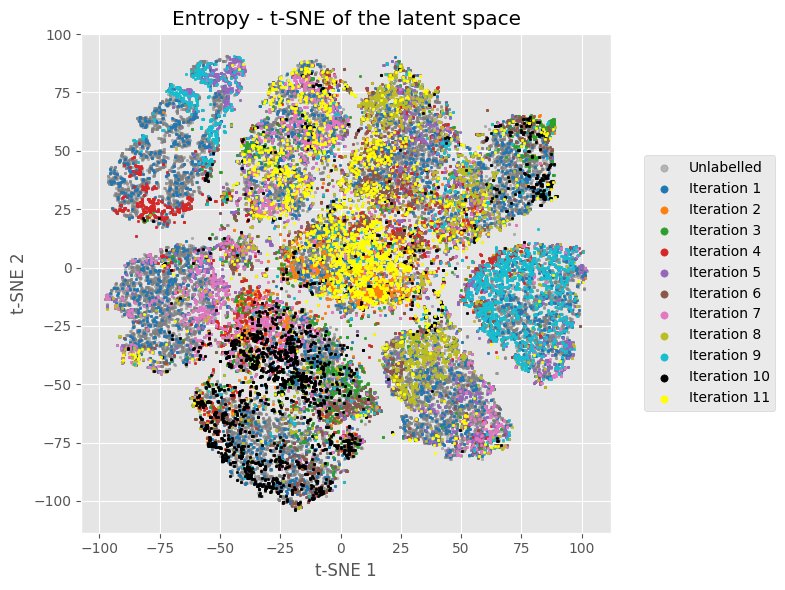

In [34]:
plot_sample_hist(z_all_tsne_entropy, idxs_hist, title= "Entropy")

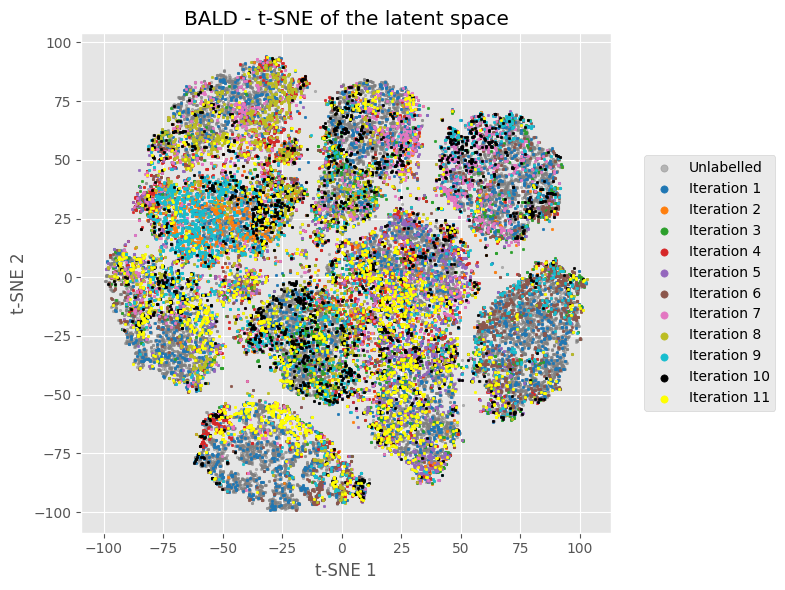

In [35]:

plot_sample_hist(z_all_tsne, idxs_hist_BALD, title = "BALD")

From the two above plots, we see that BALD is generally diversifying the datapoints to label better than the entropy. It is hard to evaluate wether one algorithm does better seperation than the other.

We would now like to focus on where we decide to do labelling. Hence we do a density plot. 

(Please note that code below was generated with assistance from LLM)

In [36]:
from scipy.stats import gaussian_kde

def create_density_heatmap(z_all_tsne, idxs_hist, title="Entropy", figsize=(7, 6), cmap='viridis'):
    cols = sample_hist(idxs_hist)
    z_all_tsne = np.array(z_all_tsne[:len(cols), :])
    cols = np.array(cols[:len(z_all_tsne)])
    """
    Create a density heatmap visualization of labeled points in t-SNE space.
    
    Parameters:
    - z_all_tsne: t-SNE coordinates of data points
    - cols: Array indicating if points are labeled (>0) or unlabeled (0)
    - figsize: Figure size
    - cmap: Colormap for density visualization
    
    Returns:
    - Figure object
    """
    plt.figure(figsize=figsize)
    
    # Filter to include only labeled points
    labeled_points = z_all_tsne[cols > 1]
    
    # Create a meshgrid for density calculation
    x_min, x_max = z_all_tsne[:, 0].min() - 1, z_all_tsne[:, 0].max() + 1
    y_min, y_max = z_all_tsne[:, 1].min() - 1, z_all_tsne[:, 1].max() + 1
    xx, yy = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    
    # Plot unlabeled points as background
    plt.scatter(z_all_tsne[cols == 0, 0], z_all_tsne[cols == 0, 1], 
                s=2, c='lightgray', alpha=0.2, label='Unlabeled')
    
    # Calculate and plot the kernel density estimate
    if len(labeled_points) > 0:
        kde = gaussian_kde(labeled_points.T)
        f = np.reshape(kde(positions), xx.shape)
        plt.imshow(f.T, extent=[x_min, x_max, y_min, y_max], 
                  origin='lower', cmap=cmap, alpha=0.7)
        
    plt.title(f"{title} - Density of AL Labeled Points in t-SNE Space")
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.colorbar(label="Density")
    plt.tight_layout()
    
    return plt.gcf()

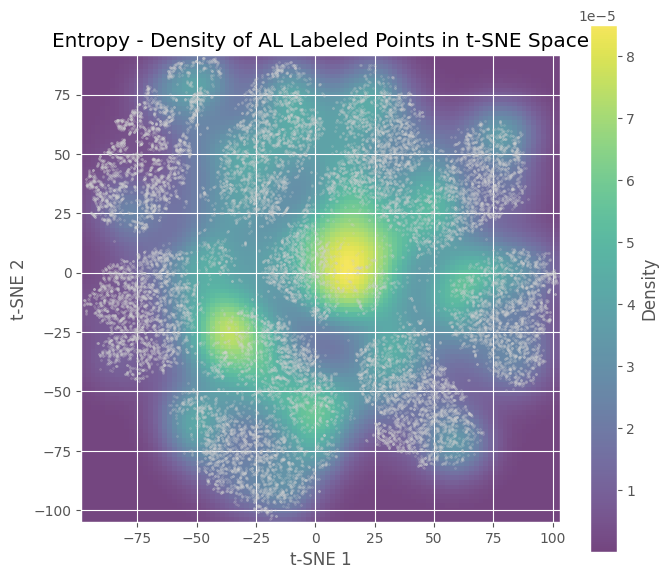

In [37]:
fig = create_density_heatmap(z_all_tsne_entropy, idxs_hist, title="Entropy")
plt.show()

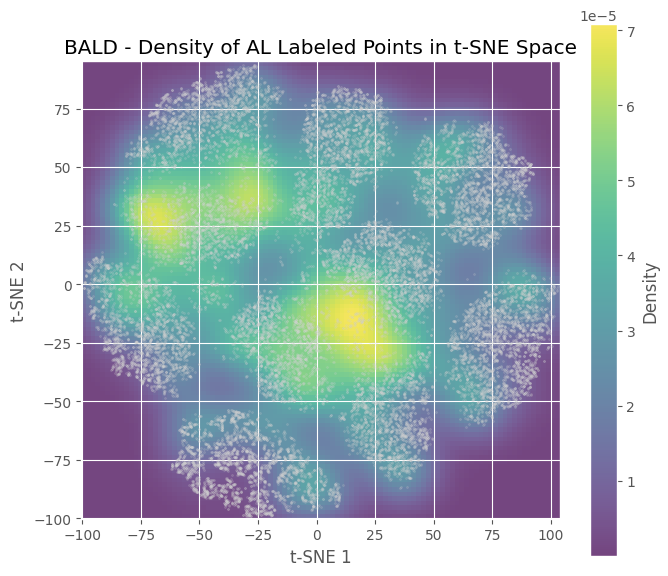

In [38]:
fig = create_density_heatmap(z_all_tsne, idxs_hist_BALD, title="BALD")
plt.show()

From the plots above, we see that both algorithms try to label near the descision boundaries of the clusters. An assessment of which algorithm is better seems infeasable so far. 

Therefore, we now try to evaluate the test accuracy with increasing amounts of labelled data.

In [45]:
fractions = [0.14, 0.18, 0.22, 0.26, 0.3, 0.34, 0.38, 0.42, 0.46, 0.5]

In [46]:
df_entropy = train_eval_to_df(results_entropy)
df_BALD = train_eval_to_df(results_BALD)

max_epoch = max(df_entropy['epoch'])
df_entropy = df_entropy[df_entropy['epoch'] == max_epoch]
df_BALD = df_BALD[df_BALD['epoch'] == max_epoch]

df_entropy['fraction'] = 1- df_entropy['fraction'].astype(float)
df_BALD['fraction'] = 1- df_BALD['fraction'].astype(float)

ValueError: 5 columns passed, passed data had 7 columns

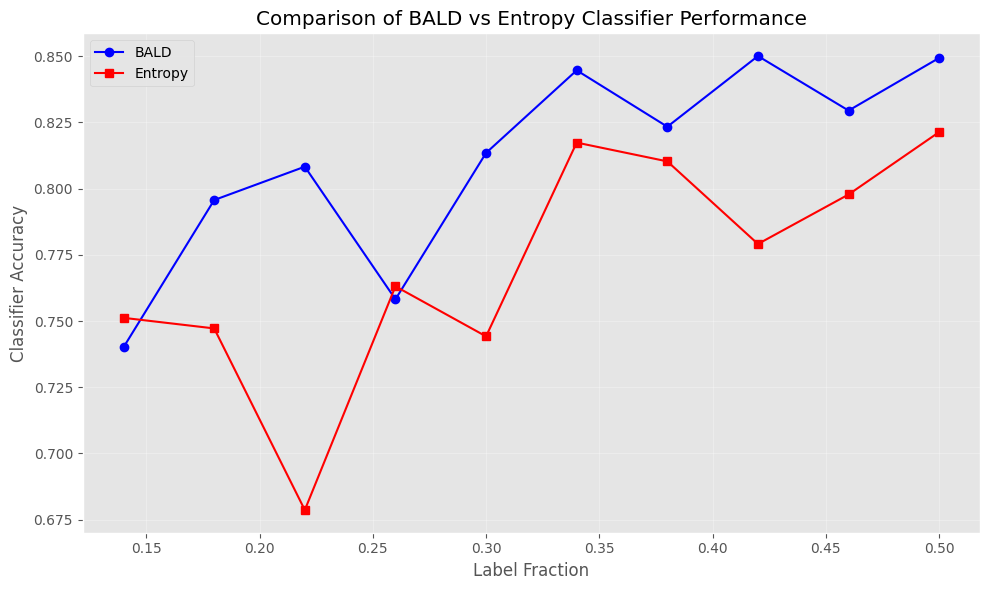

In [56]:
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(df_BALD['fraction'], df_BALD['accuracy'], 'o-', color='blue', label='BALD')
plt.plot(df_entropy['fraction'], df_entropy['accuracy'], 's-', color='red', label='Entropy')

# Customize the plot
plt.xlabel('Label Fraction')
plt.ylabel('Classifier Accuracy')
plt.title('Comparison of BALD vs Entropy Classifier Performance')
plt.grid(True, alpha=0.3)
plt.legend()

# # Reverse x-axis to show decreasing label fraction
# plt.xlim(0.88, 0.48)

plt.tight_layout()
plt.show()

We investigated how the confusion matrixes have changed, to better understand why we finally check what numbers the algorithms picked to label.

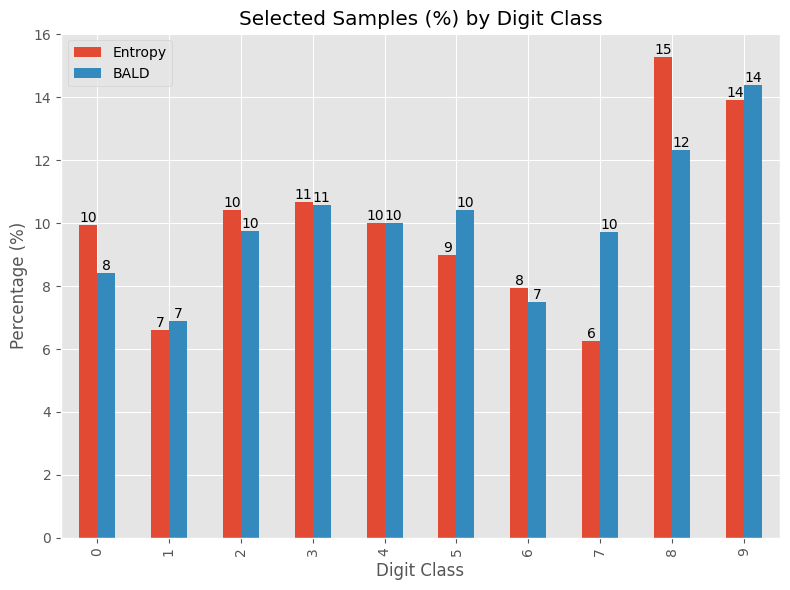

In [75]:
def plot_al_label_distribution(data_loader, idxs_hist, idxs_hist_BALD):
    # Get all data and labels
    x_all, y_all = [], []
    for x, y in data_loader:
        x_all.append(x)
        y_all.append(y)
    all_labels = np.argmax(torch.cat(y_all), axis=1).numpy()


    label_hist_entropy = sample_hist(idxs_hist)
    label_hist_BALD = sample_hist(idxs_hist_BALD)
    
    all_labels = all_labels[:len(label_hist_entropy)]
    label_hist_entropy = label_hist_entropy[:len(all_labels)]
    label_hist_BALD = label_hist_BALD[:len(all_labels)]
    # Get true labels
    entropy_labels = all_labels[label_hist_entropy>1]
    bald_labels = all_labels[label_hist_BALD>1]
    
    # Plot histograms
    fig, ax2 = plt.subplots(1, 1, figsize=(8, 6))
    
    # Count plot
    df = pd.DataFrame({
        'Entropy': np.bincount(entropy_labels, minlength=10),
        'BALD': np.bincount(bald_labels, minlength=10)
    }, index=range(10))
    
    # Percentage plot  
    df_pct = df.div(df.sum(axis=0), axis=1) * 100
    df_pct.plot(kind='bar', ax=ax2)
    ax2.set_title('Selected Samples (%) by Digit Class')
    ax2.set_xlabel('Digit Class')
    ax2.set_ylabel('Percentage (%)')
    
    for container in ax2.containers:
        ax2.bar_label(container, fmt='%.0f')
    
    plt.tight_layout()
    plt.savefig('active_learning_histogram.png', dpi=300)
    plt.show()
    plt.close()

# Usage:
plot_al_label_distribution(data_loader, idxs_hist, idxs_hist_BALD)